In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil

from PIL import Image
from IPython.display import display
import warnings
from sklearn.preprocessing import normalize
warnings.filterwarnings('ignore')

In [2]:
gtpath="catdogData/gt/"
gtfiles=[]
for folder, subfolder, filenames in os.walk(gtpath):
    for files in filenames:
        gtfiles.append(files)
        

noisepath="catdogData/noise/"
noisefiles=[]
for folder, subfolder, filenames in os.walk(noisepath):
    for files in filenames:
        noisefiles.append(files)

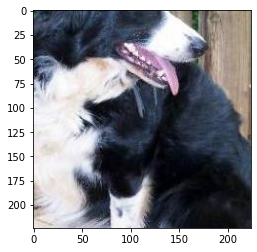

In [7]:
test=read_image(gtpath+noisefiles[0])
test=np.transpose(test,(1,2,0))

plt.imshow(test)



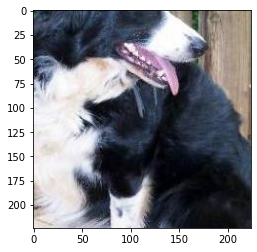

In [8]:
test2=read_image(gtpath+gtfiles[0])

test2=np.transpose(test2,(1,2,0))
plt.imshow(test2)

In [9]:
class CatdogDataset(Dataset):
    def __init__(self,data_path,target_path, filenames, transform=None):
        self.data_path=data_path
        self.target_path=target_path
        self.transform=transform
        self.filenames=filenames
        
    def __len__(self):
        
        return len(filenames)
    
    def __getitem__(self,idx):
        
        input_path=self.data_path+filenames[idx]
        target_path=self.target_path+filenames[idx]
        
        data= read_image(input_path).to(torch.float)
        target= read_image(target_path).to(torch.float)
        
        return data, target
        

In [14]:
catdogdataset= CatdogDataset(data_path=noisepath,target_path=gtpath,filenames=gtfiles)
train_size=int(0.8*len(catdogdataset))
test_size=len(catdogdataset)-train_size
trainset,testset=random_split(catdogdataset,[train_size,test_size],generator=torch.manual_seed(42))


In [15]:
class RedCNN(nn.Module):
    ##k=filter size, f=number of filters
    def __init__(self,k=5,f=96):
        
        super().__init__()
        ##Encoding Layers
        self.conv1=nn.Conv2d(in_channels=3,out_channels=f,kernel_size=k,padding=2,bias=True)
        self.conv2=nn.Conv2d(in_channels=f,out_channels=f,kernel_size=k,padding=2,bias=True)
        self.conv3=nn.Conv2d(in_channels=f,out_channels=f,kernel_size=k,padding=2,bias=True)
        self.conv4=nn.Conv2d(in_channels=f,out_channels=f,kernel_size=k,padding=2, bias= True)
        
        #Decoder layers
        
        self.d_conv1=nn.ConvTranspose2d(in_channels=f,out_channels=f,kernel_size=k,padding=2,bias=True)
        self.d_conv2=nn.ConvTranspose2d(in_channels=f,out_channels=f,kernel_size=k,padding=2,bias=True)
        self.d_conv3=nn.ConvTranspose2d(in_channels=f,out_channels=f,kernel_size=k,padding=2,bias=True)
        self.d_conv4=nn.ConvTranspose2d(in_channels=f,out_channels=f,kernel_size=k,padding=2,bias=True)
        self.d_output=nn.ConvTranspose2d(in_channels=f,out_channels=1,kernel_size=k,padding=2, bias=True)
        
        self.batchnorm=nn.BatchNorm2d(f)
        
        
    def forward(self,x):
        xinit=x
        x=F.relu(self.batchnorm(self.conv1(x)))
        x2=x.clone()
        x=F.relu(self.batchnorm(self.conv2(x)))
        x=F.relu(self.batchnorm(self.conv3(x)))
        x4=x.clone()
        x=F.relu(self.batchnorm(self.conv4(x)))
        
        ##dencode
        x=F.relu(self.batchnorm(self.d_conv1(x))+x4)
        x=F.relu(self.batchnorm(self.d_conv2(x)))
        x=F.relu(self.batchnorm(self.d_conv3(x))+x2)
        x=F.relu(self.batchnorm(self.d_conv4(x)))
        
        x=self.d_output(x)+xinit
        
        return x

In [16]:
model=RedCNN()
model

RedCNN(
  (conv1): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv1): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv2): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv3): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv4): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_output): ConvTranspose2d(96, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [18]:
criterion=nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [38]:
##Training

train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=True)

for epoch in range(5):
    losses=[]
    for i, data in enumerate(train_loader):
        
        inputt, target=data
        
        target_pred=model(inputt)
        
        loss=criterion(target_pred,target)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i%10==0):
            print(f"Epoch: {epoch} Loss:{loss.item()} Batch:{i}")
        


In [37]:
modelfile="denoise.pth.tar"

torch.save(model.state_dict(),modelfile)

In [40]:
loaded_model=RedCNN()
loaded_model.load_state_dict(torch.load(modelfile))

<All keys matched successfully>

In [50]:
loaded_model.eval()

with torch.no_grad():
    target_pred=loaded_model(next(iter(testset))[0].view(-1,3,224,224
                                                        ))

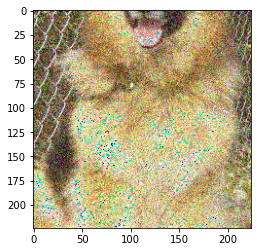

In [51]:
target_pred=target_pred.to(torch.uint8).view(-1,3,224,224)
plt.imshow(np.transpose(target_pred.view(3,224,224),(1,2,0)))


In [57]:
loss.grad()

TypeError: 'NoneType' object is not callable

In [52]:
testinput,testoutput=testset[0]

In [53]:
testinput.shape

torch.Size([3, 224, 224])

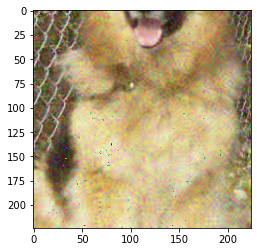

In [54]:
with torch.no_grad():
    
    testinput=testinput.view(-1,3,224,224)
    plt.imshow(np.transpose(model(testinput).view(3,224,224).to(torch.uint8),(1,2,0)))

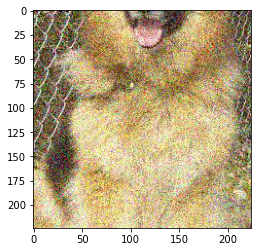

In [55]:
    plt.imshow(np.transpose(testinput.view(3,224,224).to(torch.uint8),(1,2,0)))

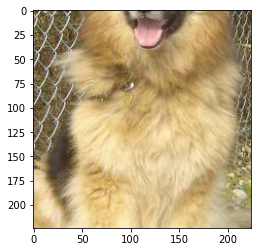

In [35]:
    plt.imshow(np.transpose(testoutput.view(3,224,224).to(torch.uint8),(1,2,0)))

In [59]:
for param in loaded_model.parameters():
    
    print(param)

FIRST###################
Parameter containing:
tensor([[[[ 1.5675e-02,  3.7085e-02,  2.8290e-02,  7.1041e-02,  7.4624e-02],
          [-9.7086e-02,  5.4188e-02,  7.4059e-02, -5.6457e-02, -7.2558e-02],
          [-1.0094e-01, -1.1526e-01,  6.5485e-02,  3.6295e-02, -6.3172e-02],
          [-1.0347e-01, -1.0791e-01,  1.0576e-01,  3.7255e-02,  2.0973e-02],
          [-6.4867e-03,  4.6784e-02,  1.3220e-02,  4.8569e-02,  2.8428e-02]],

         [[-5.9873e-02, -4.8410e-02,  3.1956e-02,  2.8620e-02,  8.1606e-02],
          [-7.9989e-02,  5.7631e-02, -1.0229e-01,  1.1987e-02, -9.4456e-02],
          [-5.5183e-02, -6.5871e-02,  1.0995e-01,  1.0702e-01, -5.0036e-02],
          [-5.7116e-03, -9.6092e-02, -9.1266e-02, -5.9211e-02,  1.4902e-02],
          [-1.0013e-01, -2.3885e-02,  1.8895e-02,  8.9772e-04, -4.6277e-03]],

         [[ 1.9272e-02,  1.1787e-01, -9.6639e-02, -8.2424e-02,  6.1498e-02],
          [ 4.0502e-02,  9.7090e-02,  9.5004e-02, -7.9983e-02, -2.6152e-02],
          [-1.0488e-01,  

In [86]:
# with torch.no_grad():
for i, j in model.state_dict().items():
    print(i)
    test=j.grad()
    v1=j
    v2=model.state_dict()[i]
    print((v1-v2).abs())

conv1.weight


TypeError: 'NoneType' object is not callable

In [105]:
# with torch.no_grad():
for i, j in model.state_dict().items():
    print(i,j.grad)
    if (i=="batchnorm.num_batches_tracked"):
        print(j)

conv1.weight None
conv1.bias None
conv2.weight None
conv2.bias None
conv3.weight None
conv3.bias None
conv4.weight None
conv4.bias None
d_conv1.weight None
d_conv1.bias None
d_conv2.weight None
d_conv2.bias None
d_conv3.weight None
d_conv3.bias None
d_conv4.weight None
d_conv4.bias None
d_output.weight None
d_output.bias None
batchnorm.weight None
batchnorm.bias None
batchnorm.running_mean None
batchnorm.running_var None
batchnorm.num_batches_tracked None
tensor(2576)


In [78]:
loaded_model.state_dict()["conv1.weight"]

tensor([[[[ 1.5675e-02,  3.7085e-02,  2.8290e-02,  7.1041e-02,  7.4624e-02],
          [-9.7086e-02,  5.4188e-02,  7.4059e-02, -5.6457e-02, -7.2558e-02],
          [-1.0094e-01, -1.1526e-01,  6.5485e-02,  3.6295e-02, -6.3172e-02],
          [-1.0347e-01, -1.0791e-01,  1.0576e-01,  3.7255e-02,  2.0973e-02],
          [-6.4867e-03,  4.6784e-02,  1.3220e-02,  4.8569e-02,  2.8428e-02]],

         [[-5.9873e-02, -4.8410e-02,  3.1956e-02,  2.8620e-02,  8.1606e-02],
          [-7.9989e-02,  5.7631e-02, -1.0229e-01,  1.1987e-02, -9.4456e-02],
          [-5.5183e-02, -6.5871e-02,  1.0995e-01,  1.0702e-01, -5.0036e-02],
          [-5.7116e-03, -9.6092e-02, -9.1266e-02, -5.9211e-02,  1.4902e-02],
          [-1.0013e-01, -2.3885e-02,  1.8895e-02,  8.9772e-04, -4.6277e-03]],

         [[ 1.9272e-02,  1.1787e-01, -9.6639e-02, -8.2424e-02,  6.1498e-02],
          [ 4.0502e-02,  9.7090e-02,  9.5004e-02, -7.9983e-02, -2.6152e-02],
          [-1.0488e-01,  4.2919e-02,  7.4595e-02, -8.6530e-02, -6.1042e-

In [102]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.grad)

conv1.weight tensor([[[[ 9.5299e-01,  1.0158e+00,  9.0065e-01,  9.8070e-01,  1.0832e+00],
          [ 8.3714e-01,  1.0657e+00,  1.0010e+00,  9.4377e-01,  8.3526e-01],
          [ 6.8266e-01,  8.4573e-01,  9.9516e-01,  9.9310e-01,  8.7181e-01],
          [ 7.1425e-01,  7.2186e-01,  8.4126e-01,  9.3049e-01,  9.1867e-01],
          [ 8.5968e-01,  8.9030e-01,  8.7214e-01,  9.5448e-01,  9.6615e-01]],

         [[ 7.1381e-01,  7.5594e-01,  6.6811e-01,  7.6656e-01,  8.9453e-01],
          [ 6.4368e-01,  8.0905e-01,  7.4559e-01,  7.3230e-01,  6.5463e-01],
          [ 5.4357e-01,  6.4252e-01,  7.6031e-01,  7.8490e-01,  6.7207e-01],
          [ 5.6247e-01,  5.3230e-01,  6.0315e-01,  7.0311e-01,  7.1567e-01],
          [ 6.6328e-01,  6.8987e-01,  6.2695e-01,  7.0330e-01,  7.4925e-01]],

         [[ 5.9616e-01,  6.5391e-01,  5.2545e-01,  5.8631e-01,  7.1680e-01],
          [ 5.1589e-01,  7.3268e-01,  6.3682e-01,  5.5071e-01,  4.6133e-01],
          [ 3.9505e-01,  5.4676e-01,  6.4868e-01,  6.0619e-

In [106]:
saved_model='easy_way.pth.tar'

torch.save(model,saved_model)

In [107]:
saved_model_load=torch.load(saved_model)

In [111]:
for name, param in saved_model_load.named_parameters():
    if param.requires_grad:
        print(name, param.grad)

conv1.weight None
conv1.bias None
conv2.weight None
conv2.bias None
conv3.weight None
conv3.bias None
conv4.weight None
conv4.bias None
d_conv1.weight None
d_conv1.bias None
d_conv2.weight None
d_conv2.bias None
d_conv3.weight None
d_conv3.bias None
d_conv4.weight None
d_conv4.bias None
d_output.weight None
d_output.bias None
batchnorm.weight None
batchnorm.bias None
